In [ ]:
import torch
import matplotlib.pyplot as plt
import random

In [2]:
from lstm import LSTM
from ddpm import DDPM, ContextUnet
from grayscott import GrayScott
from training import train_lstm, train_ddpm_on_mnist
from analyzer import Analyzer
from constants import *

In [3]:
def create_sine_dataset(samples=100, seq_len=50):
    data = []
    for _ in range(samples):
        # Random frequency and phase to make it robust
        freq = np.random.uniform(0.5, 2.0)
        phase = np.random.uniform(0, 2*np.pi)
        t = np.linspace(0, 10, seq_len)
        
        # Signal = Sine + slight noise
        signal = np.sin(freq * t + phase) + 0.05 * np.random.randn(seq_len)
        data.append(signal)
    
    # Shape: [Batch, Seq_Len, Input_Size=1]
    return torch.FloatTensor(np.array(data)).unsqueeze(2)

def create_shapes_dataset(samples=100, size=32):
    data = []
    for _ in range(samples):
        img = np.zeros((size, size))
        
        # Random Square
        x = np.random.randint(5, size-10)
        y = np.random.randint(5, size-10)
        w = np.random.randint(5, 10)
        img[x:x+w, y:y+w] = 1.0
        
        data.append(img)
        
    # Shape: [Batch, Channels=1, Height, Width]
    return torch.FloatTensor(np.array(data)).unsqueeze(1)

In [4]:
samples = create_sine_dataset(1000,50)
samples.size()

torch.Size([1000, 50, 1])

In [5]:
samples_shape = create_shapes_dataset(100,32)
samples_shape.size()

torch.Size([100, 1, 32, 32])

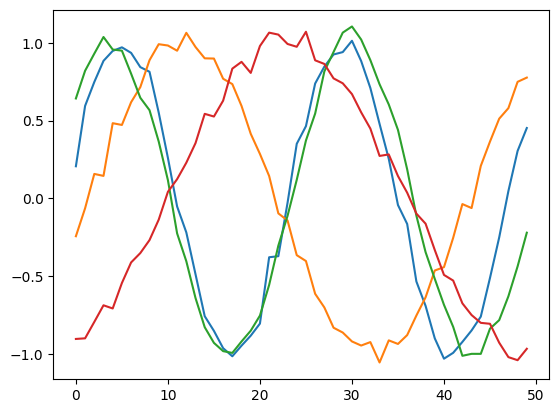

In [ ]:
for _ in range(4):
    rand_index = random.randint(0, 100)
    plt.plot(samples[rand_index,:,0])

--- Training LSTM ---
Epoch 0: Loss 0.53325
Epoch 10: Loss 0.30153
Epoch 20: Loss 0.18200
Epoch 30: Loss 0.12949
Epoch 40: Loss 0.10659
Epoch 50: Loss 0.09434
Epoch 60: Loss 0.08579
Epoch 70: Loss 0.07966
Epoch 80: Loss 0.07500
Epoch 90: Loss 0.07106


Text(0.5, 0, 'epoch')

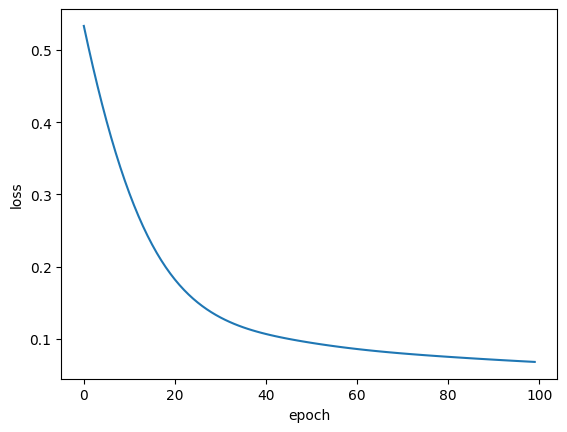

In [ ]:
# 1. Create Data
lstm_data = create_sine_dataset(samples=100, seq_len=50)

# 2. Train
lstm_model = LSTM(input_size=1, hidden_size=16)
loss = train_lstm(lstm_model, lstm_data, epochs=10)

# Use the first sample from our dataset as a "seed"
seed_sample = lstm_data[0:1, :, :] # Shape [1, 50, 1]

future_steps = 50
generated = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)

plt.plot(loss)
plt.ylabel("loss")
plt.xlabel("epoch")

In [8]:
print(f"Seed shape: {seed_sample.shape}")
print(f"Generated shape: {generated.shape}")
print(f"Generated values: {generated[0, :, 0].numpy()}")

Seed shape: torch.Size([1, 50, 1])
Generated shape: torch.Size([1, 50, 1])
Generated values: [-1.0091735  -1.117452   -1.208965   -1.2763745  -1.3090636  -1.321224
 -1.3254113  -1.3249563  -1.3212692  -1.3144704  -1.3030622  -1.2845753
 -1.255063   -1.2088352  -1.1396142  -1.0466589  -0.9452063  -0.85639846
 -0.76554024 -0.62989986 -0.46545005 -0.3259269  -0.20025516 -0.09764484
 -0.0067991   0.10861468  0.14987619  0.2534305   0.35560185  0.40100342
  0.41253692  0.37278932  0.2726398   0.14360072  0.04263657  0.01970318
  0.08245365  0.18270665  0.27892733  0.39158335  0.5198132   0.5979464
  0.60366666  0.5825145   0.5605736   0.5448271   0.5347849   0.52668625
  0.518399    0.50969815]


In [9]:
lstm_data[rand_index, :, 0]

tensor([ 0.8717,  0.9452,  1.0006,  0.9379,  0.5085,  0.2114, -0.0916, -0.4619,
        -0.8238, -0.8971, -0.9915, -0.8627, -0.6670, -0.2615,  0.1255,  0.5567,
         0.7253,  0.9107,  0.9063,  0.8550,  0.5948,  0.2625, -0.2035, -0.5544,
        -0.7721, -0.9045, -0.9669, -0.8069, -0.4643, -0.2670,  0.1418,  0.5255,
         0.8049,  0.9788,  1.0399,  0.9207,  0.6377,  0.2305, -0.1514, -0.5346,
        -0.8272, -0.9775, -1.0095, -0.8506, -0.5800, -0.2210,  0.1568,  0.5041,
         0.8175,  0.9790])

In [18]:
lstm_data[rand_index, :, 0]


tensor([ 0.5743,  0.7530,  0.8310,  0.9125,  0.9421,  1.0299,  0.9981,  1.0732,
         0.9117,  0.8209,  0.6926,  0.6364,  0.4351,  0.3746,  0.2073,  0.0190,
        -0.1597, -0.3304, -0.5006, -0.6319, -0.6631, -0.8307, -0.8943, -0.9662,
        -0.9709, -1.0824, -0.9781, -0.8840, -0.8491, -0.7375, -0.5405, -0.4296,
        -0.2709, -0.0601,  0.0049,  0.2968,  0.4413,  0.6798,  0.6119,  0.7912,
         0.9311,  0.9717,  1.0720,  1.0093,  1.0074,  0.9239,  0.8309,  0.6923,
         0.5713,  0.4822])

In [30]:
rand_index = random.randint(0, 100)
seed_sample = lstm_data[rand_index]
future_steps = 50
generated_ = lstm_model.generate_sequence(seed_sample, future_steps=future_steps)
plt.plot(torch.cat((seed_sample[0,:,0], generated_[0,:,0])))

IndexError: too many indices for tensor of dimension 2

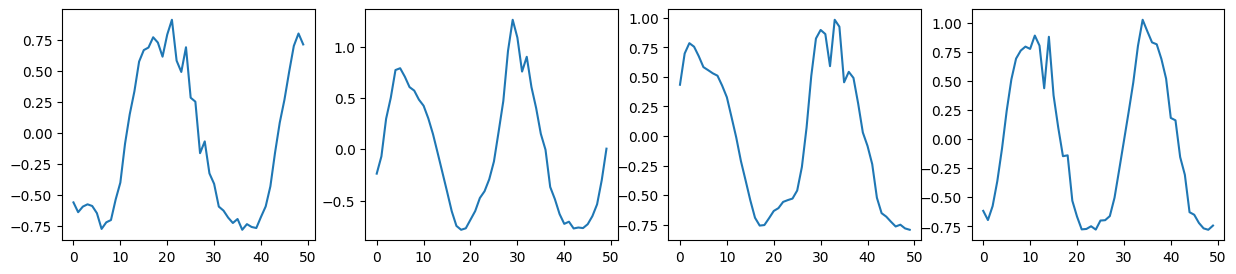

In [ ]:
lstm_out, history = lstm_model(lstm_data)
fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(4):
    rand_index = random.randint(0,100)
    ax[i].plot(lstm_out[rand_index,:,0].detach().numpy())
plt.show()

In [ ]:
history["forget"][0].size()

torch.Size([1000, 16])

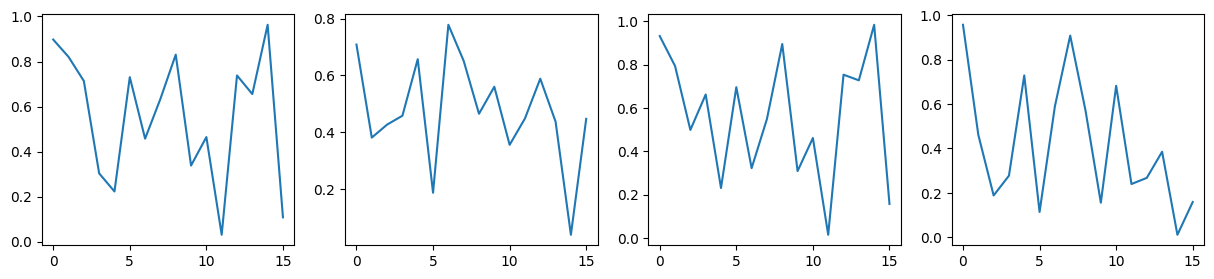

In [ ]:
fig, ax = plt.subplots(1,4, figsize=(15,3))
for i in range(4):
    rand_index = random.randint(0,16)
    ax[i].plot(history["forget"][rand_index][0].detach().numpy())
plt.show()

In [ ]:
# trained_model = train_ddpm_on_mnist()
# final_img, history = trained_model.sample(n_sample=1, size=(1, 28, 28), device="cpu")

In [ ]:
# 1. Get Gray Scott Data
# gs is your GrayScott instance
# gs_history should be a list of frames you saved during the loop
gs = GrayScott(F=F_DEFAULT, k=k_DEFAULT, D_u=Du_DEFAULT, D_v=Dv_DEFAULT, x0=x0, x1=x1, N=N)
_, V_final, V_history, _, _ = gs.forward(0, 3000, frame=False, data=False)
gs_final = V_final[1:-1, 1:-1]
gs_history = np.array(V_history) # Shape: [Time, H, W]

# 2. Get LSTM Data
# output is the predicted sequence [Batch, Seq, 1]
lstm = LSTM()
lstm_output, _ = lstm.forward(lstm_data)
lstm_final = lstm_output[0, :, 0].detach().cpu().numpy()
lstm_history = lstm_output[0, :, :].detach().cpu().numpy() # Treat sequence as history

# 3. Get DDPM Data
# final_img is [1, 28, 28]
# history is list of arrays [Time, 1, 28, 28]
# ddpm_final = ddpm_final_img.squeeze().cpu().numpy()
# ddpm_history = np.array([x.squeeze() for x in ddpm_history_list])
ddpm_final = np.zeros((28,28))
ddpm_history = np.zeros((time_length, 1, 28,28))

# 4. Run Comparison
analyzer = ResearchAnalyzer()
analyzer.compare_models(gs_final, gs_history, 
                        lstm_final, lstm_history, 
                        ddpm_final, ddpm_history)

F=0.054, k=0.062: 100%|███████████████████████████████████████▉| 4910/4915 [00:08<00:00, 572.18it/s]
